<a href="https://colab.research.google.com/github/haythemmz/Cancer_prediction/blob/master/two_steps_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install darts

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from darts.metrics import mae,mape
from darts import TimeSeries


In [ ]:
direction='/content/drive/MyDrive/jsv/jsv data/d_80.csv'
df_80=pd.read_csv(direction,error_bad_lines=False,sep=',')

In [ ]:
df_80.head(2)

In [12]:

class ETL():

    def __init__(self,df,value,time) -> None:
        self.data=df
        self.value=value
        self.time=time
        self.without_2020=True
        self.without_2007=True
        self.ts=pd.pivot_table(self.data,index=['ItemCode'],columns=self.time,values=self.value,aggfunc=np.sum,fill_value=0)
    
    

    def make_item_time_series(self,item_name):
        first_item=self.time[0]
        second_time=self.time[1]
        ts=self.ts
        d_test=ts.loc[[item_name]].T.reset_index()
        d_test[first_item]=d_test[first_item].apply(int)
        if self.without_2020==True:
            d_test=d_test[d_test[first_item]<2020]
        if self.without_2007==True:
            d_test=d_test[d_test[first_item]>2007]
        
        d_test['date']=d_test[first_item].apply(str)+'-'+d_test[second_time].apply(str)+'-'+'1'
        d_test['date']=d_test['date'].apply(pd.to_datetime)
        
        return d_test[['date',item_name]].set_index('date')

    

    def feature_enginnering(self,item_name):

        s=self.make_item_time_series(item_name)
        s['sale_or_not']=s[item_name].apply(lambda x : 1 if x>0 else 0)
        s['sold_last_year']=s['sale_or_not'].shift(12)
        s['sold_two_years']=s['sale_or_not'].shift(24)
        s['month']=s.index.month
        s['year']=s.index.year
        s=s.dropna()
        s_copy=s
        s_copy['year']=s_copy.index.year
        years=list(s_copy['year'].unique())
  
        r=dict()
        for y in range(1,len(years)):
            l=list(s_copy[s_copy['year']==years[y]][item_name])
            a=0
            for x in l:
                if x ==0:
                    a=a+1
            r[years[y]]=a
        d=pd.DataFrame.from_dict(r, orient='index',columns=['last_year_zeros'])
        s=pd.merge(s,d,left_on='year',right_on=d.index,how='left')
        s=s.dropna()
        l=list(s[item_name])
        b=[l[0]]
        for i in range(1,len(l)):
            if l[i-1]==0:
                b.append(b[i-1])
            else:
                b.append(l[i-1])
        
        
        s['last_value']=b
        s=s.dropna()
        l=list(s[item_name])
        r=[np.nan]
        for i in range(1,len(l)):
            a=np.nan
            for j in range(i,-1,-1):
                if l[j]!=0:
                    a=j
                    break
            b=np.nan
            if (np.isnan(a) == False) and (a>0): 
                for u in range(a-1,-1,-1):
                    if l[u] !=0:
                        b=u
                        break 
            try :
                c=a-b 
            except:
                c=np.nan 
            r.append(c)
        
        s['non_zero_inter']=r
        s=s.dropna()
        l=list(s[item_name])
        a=0
        for i in l:
            if i>0:
                break  
            else:
                a=a+1
        
        n=a
        s=s[n:]

        a=[1]
        for i in range(1,len(l)) :
            c=i-1
            o=1
            while l[c]==0:
                c=c-1
                o=o+1
            a.append(o)
        s['last_one']=a
        return s

    def get_true(self,item_name,year):
        serie=self.make_item_time_series(item_name)
        s=serie[serie.index.date>=datetime.date(datetime.strptime('01/01/'+year, '%d/%m/%y'))]
        return s

    def inter_demand(self,item_name):
        df=self.make_item_time_series(item_name)
        a=list(df[item_name])
        d=list(df.index)
        aa=np.max(np.nonzero(a))
        b=[]
        c=[]
        for i in range(aa):
            if a[i]!=0 :
                c.append(d[i])
                q=1
                for j in range(i+1,len(a)):
                    if a[j]==0:
                        q=q+1
                    else:
                        break 
                b.append(q)
        out=pd.DataFrame(data=[c,b]).T
        out.columns = ['date','inter_demand']
        return out

    def non_zero_demand(self,item_name):
        df=self.make_item_time_series(item_name)
        return df[df[item_name]!=0]

In [16]:
transformer=ETL(df=df_80,value='LineTotal',time=['year','month'])
s=transformer.get_true(item_name='T8401134',year='19')
non_zero=transformer.non_zero_demand(item_name='T8401134')

In [13]:
def get_train_test_for_darts(non_zero,name):
  fake_time=pd.date_range(start=non_zero.index.min(),periods=len(non_zero),freq='M')
  fake_serie=pd.Series(data=non_zero[name].values,index=fake_time)
  ts_non_zero=TimeSeries.from_series(fake_serie)
  val=non_zero[non_zero.index.date>=datetime.date(datetime.strptime('01/01/'+'19', '%d/%m/%y'))]
  val_size=len(val)
  train,test=ts_non_zero[:-val_size], ts_non_zero[-val_size:]
  return train, test 



In [14]:
def modeling(models,name,train,test):
  predictions=dict()
  predictions['true']=test
  for model in models:
    model.fit(train)
    pred_val = model.predict(len(test))
    predictions[str(model)+'_pred']=pred_val
  return predictions

In [14]:
items=df_80['ItemCode'].unique()

In [53]:
def meta_data(a):
    std_=np.nanstd(np.where(np.isclose(a,0), np.nan, a))
    freq_=np.count_nonzero(a)
    max_=np.max(a)
    min_=np.nanmin(np.where(np.isclose(a,0), np.nan, a))
    shape=a.shape[0]
    return [std_,freq_,shape,max_,min_]

In [54]:
ts=transformer.make_item_time_series(item_name='T8401134')
df=ts['T8401134'].values
meta_data(df)


[4443.444518661905, 101, 144, 29825.25, 22.45]

In [ ]:
col=['std','non_zero','len','max','min']
items=df_80['ItemCode'].unique()
list_meta=[]
for i in items:
  ts=transformer.make_item_time_series(item_name=i)
  df=ts[i].values
  m=meta_data(df)
  list_meta.append(m)




In [58]:
df_meta=pd.DataFrame(data=list_meta,index=items,columns=col)

In [59]:
df_meta.head()

,std,non_zero,len,max,min
INF105115P,42.818820,129,144,224.32,3.58
VTEK114300,83.046188,134,144,398.50,4.45
VTEK114400,120.404369,118,144,734.83,3.31
INF205013,621.290210,144,144,4917.70,79.29
IRWV11R,531.790638,144,144,3228.56,56.19


In [61]:
df_meta.shape

(3717, 5)

In [66]:
df_meta["combined"] = list(zip(df_meta['std'],df_meta['non_zero']))

combined_weight = df_meta['combined'].value_counts(normalize=True)

df_meta['combined_weight'] = df_meta['combined'].apply(lambda x: combined_weight[x])

df_sample = df_meta.sample(300, weights=df_meta['combined_weight'])

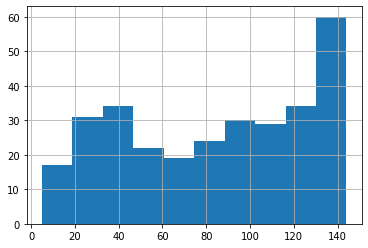

In [74]:
df_sample['non_zero'].hist()

In [15]:
transformer.make_item_time_series(items[0])[items[0]].astype(bool).sum(axis=0)

129

In [17]:
results=dict()
models = [AutoARIMA(),  ExponentialSmoothing(),  FFT(nr_freqs_to_keep=20)]
for i in items:
  try:
    train,test=get_train_test_for_darts(name=i)
    predictions=modeling(models,i,train,test)
    results['item']=i
    results['predictions']=predictions
  except:
    pass
results

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

{'item': 'JET502063',
 'predictions': {'Auto-ARIMA_pred': <TimeSeries (DataArray) (time: 6, component: 1, sample: 1)>
  array([[[888.68666667]],
  
         [[888.68666667]],
  
         [[888.68666667]],
  
         [[888.68666667]],
  
         [[888.68666667]],
  
         [[888.68666667]]])
  Coordinates:
    * time       (time) datetime64[ns] 2019-01-31 2019-02-28 ... 2019-06-30
    * component  (component) object '0'
  Dimensions without coordinates: sample,
  'ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=12_pred': <TimeSeries (DataArray) (time: 6, component: 1, sample: 1)>
  array([[[ 687.91232167]],
  
         [[ 913.85056973]],
  
         [[ 701.68232374]],
  
         [[1146.17860218]],
  
         [[ 567.69315266]],
  
         [[ 981.63205468]]])
  Coordinates:
    * time       (time) datetime64[ns] 2019-01-31 2019-02-28 ... 2019-06-30
    * component  (component) object '0'
  Dimensions without coordinates: sa

In [24]:
models = [AutoARIMA(), Prophet(), ExponentialSmoothing(), Theta(), FFT(nr_freqs_to_keep=20)]
val=non_zero[non_zero.index.date>=datetime.date(datetime.strptime('01/01/'+'19', '%d/%m/%y'))]
val_size=len(val)
train,test=ts_non_zero[:-val_size], ts_non_zero[-val_size:]
for model in models:
    model.fit(train)
    pred_val = model.predict(val_size)
    print(str(model) + " MAE: " + str(mape(pred_val,test)))



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Auto-ARIMA MAE: 92.81547376333849
Prophet MAE: 5770.47176793394
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=12 MAE: 89.78070633269299
Theta(2) MAE: 164.56240511691814
FFT(nr_freqs_to_keep=20, trend=None) MAE: 93.83732818846427


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
ts_non_zero[:4]

In [ ]:
s=non_zero[non_zero.index.date>=datetime.date(datetime.strptime('01/01/'+'19', '%d/%m/%y'))]

In [1]:
results

NameError: ignored

In [ ]:
non_zero['T8401134'].values

array([1.240000e+03, 6.200000e+02, 2.185500e+03, 3.189900e+03,
       5.301000e+03, 7.404350e+03, 7.494250e+03, 3.301500e+03,
       1.029665e+04, 5.401750e+03, 1.689500e+03, 1.712750e+03,
       2.503250e+03, 1.185750e+03, 5.270000e+02, 7.818000e+03,
       5.406400e+03, 3.937500e+02, 1.302700e+04, 6.847250e+03,
       2.108000e+03, 9.222500e+02, 7.102500e+03, 1.023750e+04,
       2.224420e+03, 4.470150e+03, 2.899800e+03, 1.666035e+04,
       1.136700e+04, 5.728100e+03, 4.720600e+03, 1.076000e+03,
       1.526660e+03, 2.982525e+04, 1.450000e+03, 7.250000e+02,
       4.366500e+03, 9.393750e+03, 1.682000e+03, 7.250000e+02,
       8.970000e+02, 2.182500e+03, 2.062500e+03, 5.979000e+03,
       4.101850e+03, 4.411250e+03, 4.178530e+03, 3.010000e+02,
       3.676280e+03, 2.285320e+03, 1.760370e+03, 1.390350e+03,
       5.984000e+01, 1.390350e+03, 6.450000e+03, 7.101300e+02,
       2.840500e+03, 3.039430e+03, 5.390250e+03, 1.043840e+04,
       5.340500e+03, 8.236150e+03, 3.750000e+02, 1.2271

In [ ]:
test=TimeSeries.from_values(non_zero['T8401134'].values)

In [ ]:
model = ExponentialSmoothing()

In [ ]:
from darts.dataprocessing.transformers import Scaler

In [ ]:
test=non_zero[non_zero.index.date>=datetime.date(datetime.strptime('01/01/'+'19', '%d/%m/%y'))]
train=non_zero[non_zero.index.date<datetime.date(datetime.strptime('01/01/'+'19', '%d/%m/%y'))]
ts_test=TimeSeries.from_values(test['T8401134'].values)
ts_train=TimeSeries.from_values(train['T8401134'].values)


In [ ]:
transformer = Scaler()
train_transformed = transformer.fit_transform(ts_train)
val_transformed = transformer.transform(ts_test)
series_transformed = transformer.transform(ts_non_zero)

In [ ]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="non_zero_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)